In [ ]:
!pip install gdown timm tqdm torchinfo --quiet

import gdown
file_id = '123456789'  # Replace with the actual file ID
output = '/content/Insect_Dataset.tar.xz'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)
print("Dataset downloaded!")

Downloading...
From (original): https://drive.google.com/uc?id=1xRZiUtu4OxLa4lQ_tdHJ3EUPIhtXbOoA
From (redirected): https://drive.google.com/uc?id=1xRZiUtu4OxLa4lQ_tdHJ3EUPIhtXbOoA&confirm=t&uuid=32f8a383-1957-4613-889c-26bdfb09babb
To: /content/Insect_Dataset.tar.xz
100%|██████████| 654M/654M [00:04<00:00, 141MB/s]

Dataset downloaded!


In [2]:
!tar -xf Insect_Dataset.tar.xz
print("Extraction complete!")
!ls /content/Insect_Dataset | head -5  # Show first 5 classes

Extraction complete!
alfalfa plant bug
alfalfa weevil
army worm
asiatic rice borer
beet fly


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os, random, shutil
from tqdm import tqdm
import torchinfo  # for model summary

In [4]:
IMG_SIZE = 256
BATCH_SIZE = 32

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Transforms ready (optimized for Swin V2)")

Transforms ready (optimized for Swin V2)


In [5]:
data_dir = '/content/Insect_Dataset'
split_dir = '/content/Insect_Dataset_Split'
os.makedirs(split_dir, exist_ok=True)

for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(split_dir, split), exist_ok=True)

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path): continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(images)

    n = len(images)
    n_train = int(0.8 * n)
    n_val = int(0.1 * n)

    splits = {
        'train': images[:n_train],
        'val': images[n_train:n_train+n_val],
        'test': images[n_train+n_val:]
    }

    for split_name, img_list in splits.items():
        dest_dir = os.path.join(split_dir, split_name, class_name)
        os.makedirs(dest_dir, exist_ok=True)
        for img in img_list:
            shutil.copy2(os.path.join(class_path, img), dest_dir)

print("Dataset split complete!")

Dataset split complete!


In [6]:
data_dir_split = '/content/Insect_Dataset_Split'

train_dataset = datasets.ImageFolder(os.path.join(data_dir_split, 'train'), train_transforms)
val_dataset   = datasets.ImageFolder(os.path.join(data_dir_split, 'val'),   val_transforms)
test_dataset  = datasets.ImageFolder(os.path.join(data_dir_split, 'test'),  val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

num_classes = len(train_dataset.classes)
print(f"Classes: {num_classes}")
print(f"Train samples: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Classes: 15
Train samples: 12518, Val: 1559, Test: 1577


In [7]:
# Swin Transformer V2 Tiny (256px window)
model = timm.create_model('swinv2_tiny_window16_256', pretrained=True, num_classes=num_classes)

# Optional: Smaller/faster variants
# model = timm.create_model('swinv2_small_window16_256', pretrained=True, num_classes=num_classes)
# model = timm.create_model('swinv2_base_window16_256', pretrained=True, num_classes=num_classes)

print("Swin Transformer V2 Tiny loaded!")
torchinfo.summary(model, input_size=(1, 3, 256, 256))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/119M [00:00<?, ?B/s]

Swin Transformer V2 Tiny loaded!


Layer (type:depth-idx)                             Output Shape              Param #
SwinTransformerV2                                  [1, 15]                   --
├─PatchEmbed: 1-1                                  [1, 64, 64, 96]           --
│    └─Conv2d: 2-1                                 [1, 96, 64, 64]           4,704
│    └─LayerNorm: 2-2                              [1, 64, 64, 96]           192
├─Sequential: 1-2                                  [1, 8, 8, 768]            --
│    └─SwinTransformerV2Stage: 2-3                 [1, 64, 64, 96]           --
│    │    └─Identity: 3-1                          [1, 64, 64, 96]           --
│    │    └─ModuleList: 3-2                        --                        229,638
│    └─SwinTransformerV2Stage: 2-4                 [1, 32, 32, 192]          --
│    │    └─PatchMerging: 3-3                      [1, 32, 32, 192]          74,112
│    │    └─ModuleList: 3-4                        --                        898,572
│    └─SwinTransf

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Helps Swin converge better
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.05)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

print(f"Training on: {device}")

Training on: cuda


In [9]:
EPOCHS = 20
best_acc = 0.0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    # Training
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    loop = tqdm(train_loader, leave=False)
    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, pred = outputs.max(1)
        total += labels.size(0)
        correct += pred.eq(labels).sum().item()

        loop.set_postfix(loss=train_loss/(loop.n+1), acc=100.*correct/total)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, pred = outputs.max(1)
            total += labels.size(0)
            correct += pred.eq(labels).sum().item()

    val_acc = 100. * correct / total
    scheduler.step()

    print(f"Train Loss: {train_loss/len(train_loader):.4f} | Train Acc: {100.*correct/total:.2f}%")
    print(f"Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_swinv2_tiny_insect.pth')
        print(f"Best model saved! Val Acc: {best_acc:.2f}%")

print(f"\nTraining Complete! Best Validation Accuracy: {best_acc:.2f}%")


Epoch 1/20


Train Loss: 1.7197 | Train Acc: 65.62%
Val Loss: 1.4302 | Val Acc: 65.62%
Best model saved! Val Acc: 65.62%

Epoch 2/20


Train Loss: 1.4198 | Train Acc: 64.91%
Val Loss: 1.4368 | Val Acc: 64.91%

Epoch 3/20


Train Loss: 1.3013 | Train Acc: 74.21%
Val Loss: 1.2254 | Val Acc: 74.21%
Best model saved! Val Acc: 74.21%

Epoch 4/20


Train Loss: 1.2366 | Train Acc: 74.92%
Val Loss: 1.1864 | Val Acc: 74.92%
Best model saved! Val Acc: 74.92%

Epoch 5/20


Train Loss: 1.1780 | Train Acc: 73.51%
Val Loss: 1.2559 | Val Acc: 73.51%

Epoch 6/20


Train Loss: 1.1160 | Train Acc: 75.63%
Val Loss: 1.1829 | Val Acc: 75.63%
Best model saved! Val Acc: 75.63%

Epoch 7/20


Train Loss: 1.0679 | Train Acc: 74.66%
Val Loss: 1.2243 | Val Acc: 74.66%

Epoch 8/20


Train Loss: 1.0001 | Train Acc: 79.86%
Val Loss: 1.0961 | Val Acc: 79.86%
Best model saved! Val Acc: 79.86%

Epoch 9/20


Train Loss: 0.9450 | Train Acc: 79.73%
Val Loss: 1.0842 | Val Acc: 79.73%

Epoch 10/20


Train Loss: 0.8985 | Train Acc: 81.40%
Val Loss: 1.0559 | Val Acc: 81.40%
Best model saved! Val Acc: 81.40%

Epoch 11/20


Train Loss: 0.8477 | Train Acc: 81.21%
Val Loss: 1.0426 | Val Acc: 81.21%

Epoch 12/20


Train Loss: 0.7962 | Train Acc: 81.46%
Val Loss: 1.0301 | Val Acc: 81.46%
Best model saved! Val Acc: 81.46%

Epoch 13/20


Train Loss: 0.7496 | Train Acc: 81.91%
Val Loss: 1.0558 | Val Acc: 81.91%
Best model saved! Val Acc: 81.91%

Epoch 14/20


Train Loss: 0.7213 | Train Acc: 83.32%
Val Loss: 1.0230 | Val Acc: 83.32%
Best model saved! Val Acc: 83.32%

Epoch 15/20


Train Loss: 0.6889 | Train Acc: 84.22%
Val Loss: 1.0063 | Val Acc: 84.22%
Best model saved! Val Acc: 84.22%

Epoch 16/20


Train Loss: 0.6670 | Train Acc: 84.67%
Val Loss: 0.9983 | Val Acc: 84.67%
Best model saved! Val Acc: 84.67%

Epoch 17/20


Train Loss: 0.6465 | Train Acc: 85.44%
Val Loss: 0.9844 | Val Acc: 85.44%
Best model saved! Val Acc: 85.44%

Epoch 18/20


Train Loss: 0.6366 | Train Acc: 85.25%
Val Loss: 0.9850 | Val Acc: 85.25%

Epoch 19/20


Train Loss: 0.6316 | Train Acc: 85.44%
Val Loss: 0.9828 | Val Acc: 85.44%

Epoch 20/20


Train Loss: 0.6235 | Train Acc: 85.12%
Val Loss: 0.9869 | Val Acc: 85.12%

Training Complete! Best Validation Accuracy: 85.44%


In [10]:
model.load_state_dict(torch.load('best_swinv2_tiny_insect.pth'))
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Classification Report")
print(classification_report(y_true, y_pred, target_names=test_dataset.classes, digits=4))

Classification Report
                            precision    recall  f1-score   support

Mango flat beak leafhopper     0.9375    0.8036    0.8654        56
         alfalfa plant bug     0.9136    0.9024    0.9080        82
            alfalfa weevil     0.7429    0.7222    0.7324       108
                 army worm     0.8759    0.9293    0.9018       410
        asiatic rice borer     0.6875    0.6471    0.6667        51
                  beet fly     0.9459    0.8750    0.9091        80
        brown plant hopper     0.7979    0.8333    0.8152        90
                corn borer     0.7573    0.7222    0.7393       108
                 green bug     0.7547    0.5556    0.6400        72
         paddy stem maggot     0.6752    0.7453    0.7085       106
          rice leaf roller     0.6604    0.7000    0.6796        50
           rice shell pest     0.9032    0.9767    0.9385        86
       tarnished plant bug     0.9643    0.9643    0.9643       140
       white margined mot

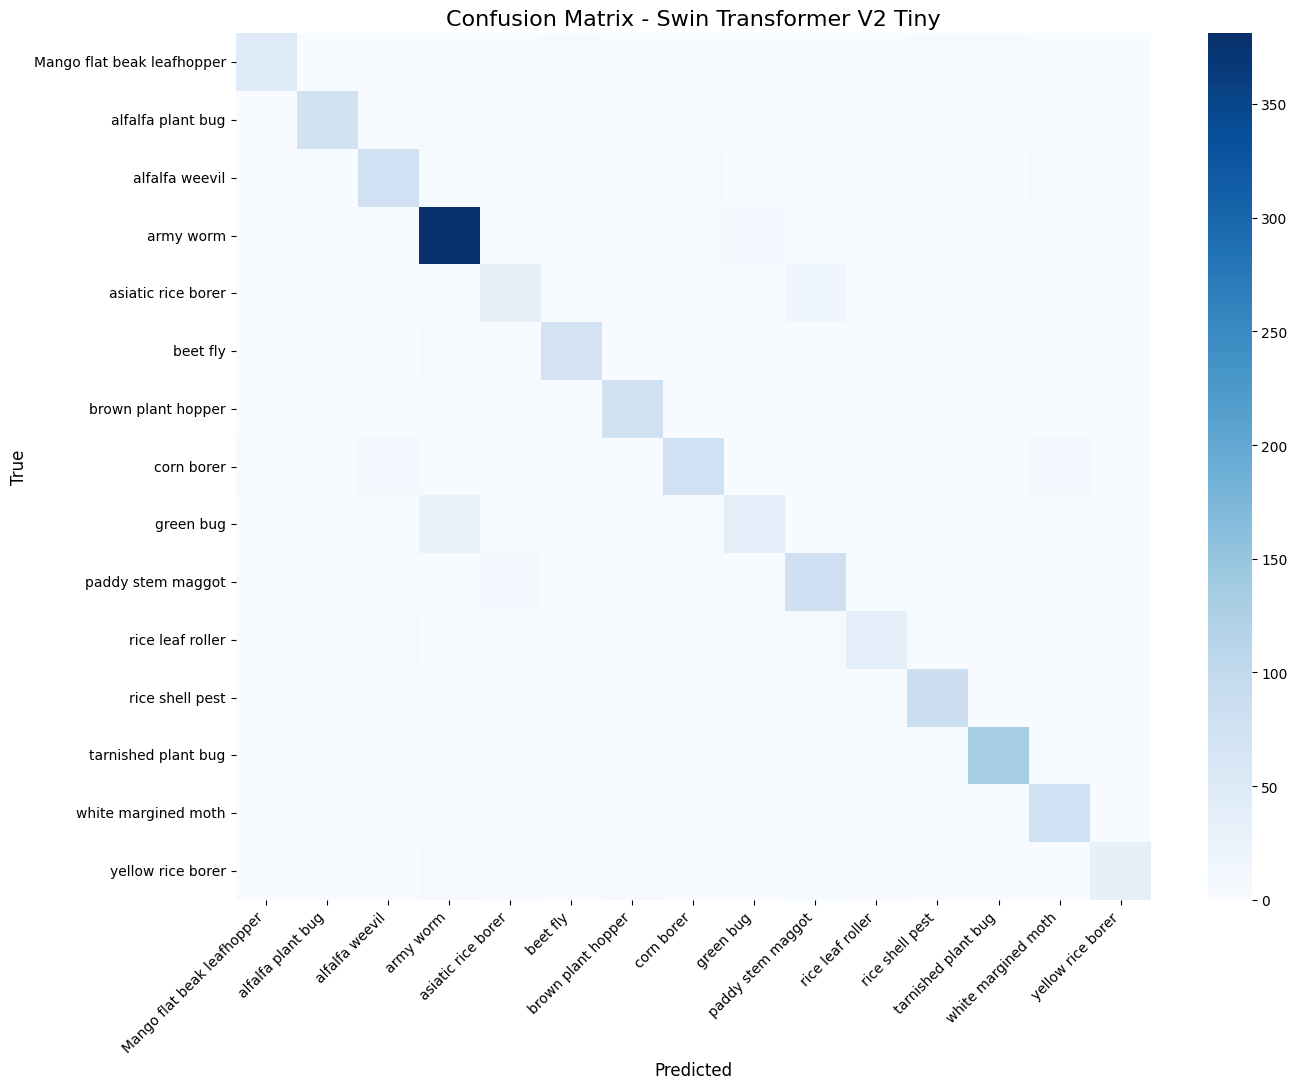

In [15]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14, 11))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.title("Confusion Matrix - Swin Transformer V2 Tiny", fontsize=16)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [13]:
!pip install onnxscript

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.0/683.0 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 5.4 MB/s eta 0:00:00


In [14]:
# Save full model
torch.save(model, 'swinv2_tiny_insect_full.pth')
print("Full model saved!")

# Export to ONNX (for deployment)
dummy = torch.randn(1, 3, 256, 256).to(device)
torch.onnx.export(model, dummy, "swinv2_tiny_insect.onnx",
                  input_names=["input"], output_names=["output"],
                  dynamic_axes={'input': {0: 'batch'}, 'output': {0: 'batch'}})
print("ONNX model exported!")

Full model saved!


/tmp/ipython-input-337391082.py:7: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(model, dummy, "swinv2_tiny_insect.onnx",


[torch.onnx] Obtain model graph for `SwinTransformerV2([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `SwinTransformerV2([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 117 of general pattern rewrite rules.
ONNX model exported!
